# Statistical and Exploratory Data Analysis

## Importing Libraries & Loading data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import chi2_contingency

import re

%matplotlib inline

In [4]:
df = pd.read_csv('../data/raw/new_Base_CDM_balanced_V2.csv', delimiter=';', header=[0, 1])
print(f"Shape of the dataframe: {df.shape}")
df.head()

Shape of the dataframe: (25782, 8)


,Y,X1,X2,X3,X4,X5,X6,X7
,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature
0,No_Displ,2.0,20.20,47400,36,CORA,72.0,No_Feat
1,No_Displ,2.0,11.90,62000,24,LECLERC,48.0,No_Feat
2,No_Displ,8.0,29.52,60661,60,AUCHAN,480.0,No_Feat
3,No_Displ,2.0,16.20,59677,19,CARREFOUR,38.0,No_Feat
4,No_Displ,5.0,62.10,142602,50,CORA,250.0,No_Feat


The dataset contains 8 columns, 7 features (`X1` to `X7`) and 1 target `Y`.
It contains 25782 observations.

In [5]:
df.columns = [x + '_' + y for x, y in df.columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25782 entries, 0 to 25781
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Y_Display            25782 non-null  object 
 1   X1_cor_sales_in_vol  25782 non-null  float64
 2   X2_cor_sales_in_val  25782 non-null  float64
 3   X3_CA_mag            25782 non-null  int64  
 4   X4_value             25782 non-null  int64  
 5   X5_ENSEIGNE          25782 non-null  object 
 6   X6_VenteConv         25782 non-null  float64
 7   X7_Feature           25782 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.6+ MB


There seems to be no missing values, and columns are encoded in suitable data types.

## EDA

### Numerical and Categorical Distributions

In [7]:
categorical_features = [column for column in df.columns if re.match('^X[57]',column)]
numerical_features = [column for column in df.columns if re.match('^X[12346]',column)]
target = [column for column in df.columns if re.match('^Y',column)]

In [8]:
df[numerical_features].describe()

,X1_cor_sales_in_vol,X2_cor_sales_in_val,X3_CA_mag,X4_value,X6_VenteConv
count,25782.000000,25782.000000,25782.000000,25782.000000,25782.000000
mean,13.767151,130.888312,64641.184431,37.646614,587.855260
std,38.203406,372.649805,54924.645702,23.498949,1821.338396
min,1.000000,1.110000,1693.000000,1.000000,1.000000
25%,2.000000,13.360000,21394.000000,25.000000,50.000000
50%,4.000000,31.050000,51522.000000,32.000000,120.000000
75%,11.000000,87.450000,91000.000000,40.000000,380.000000
max,1475.000000,13589.220000,284844.000000,198.000000,48816.000000


- Numerical features are in different scale and range.
- All features are right skewed, we can tell by the big difference between the last third quartile and the maximum of each feature.
- We can't rely on the mean and standard deviation to explain the data, instead we need to refer to the median and interquartile range to determine the central tendency and variation of the data.

In [9]:
df[target + categorical_features].describe()

,Y_Display,X5_ENSEIGNE,X7_Feature
count,25782,25782,25782
unique,2,19,2
top,No_Displ,CARREFOUR,No_Feat
freq,13000,4629,19495


- The target feature has 2 classes, both being represented at almost the same percentage.
- The `ENSEIGNE` feature has lots of classes (19), leading to some having a small percentage in our dataset, and we might think of combining rare ones and ones with similar properties to reduce the complexity.

In [10]:
def hist_and_box_plot(col):
    fig, ax = plt.subplots(1, 2)
    ax[0].hist(x=df[col], bins=30)
    ax[1].boxplot(x=df[col])
    plt.suptitle(f'Feature {col}')
    plt.tight_layout()
    plt.show()

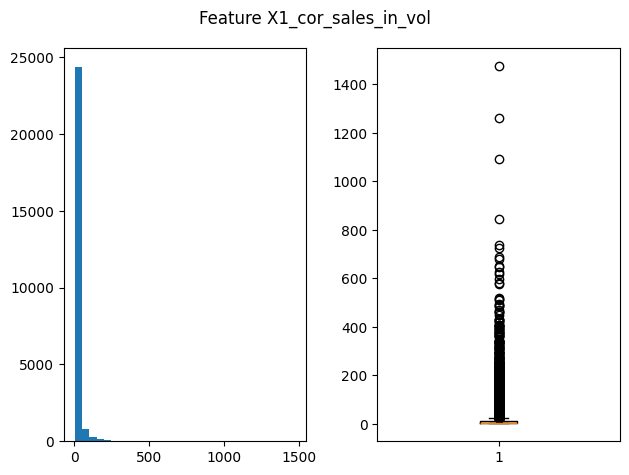

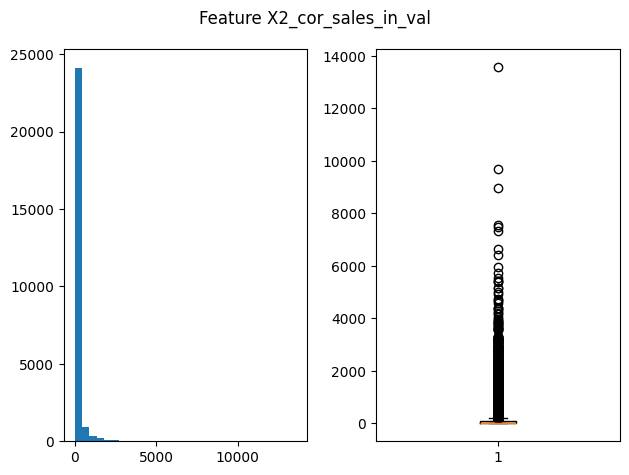

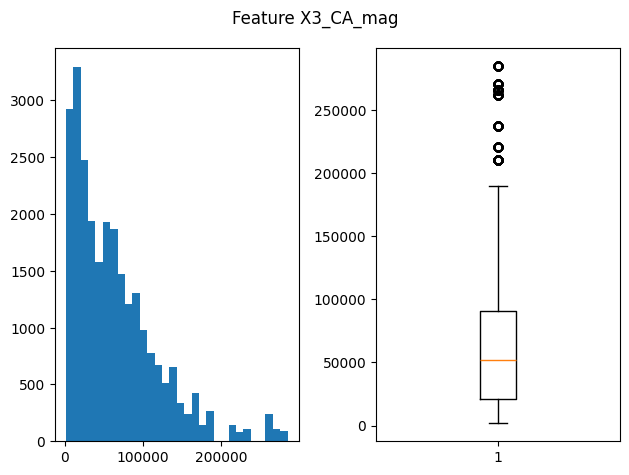

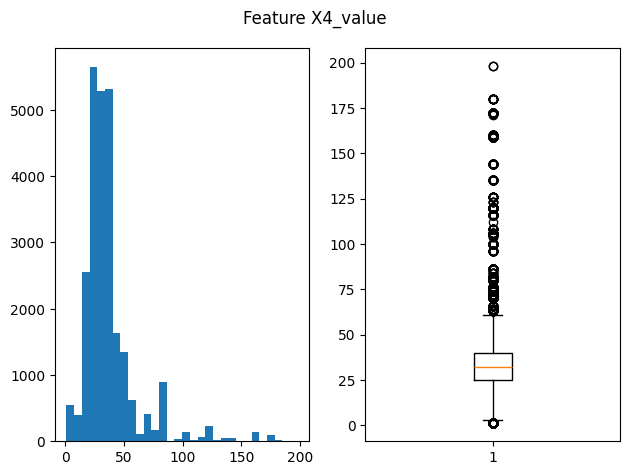

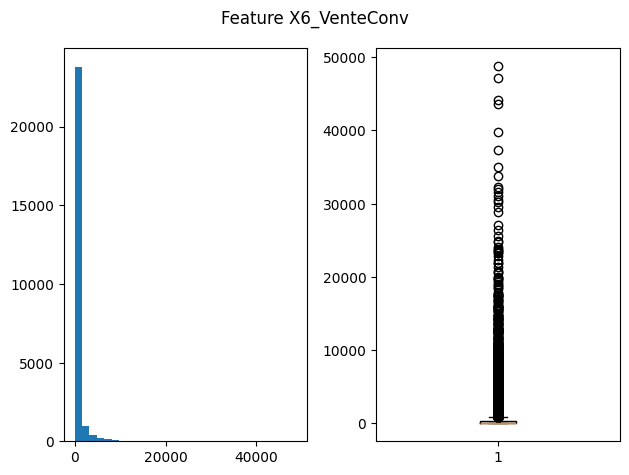

In [11]:
for i in numerical_features:
    hist_and_box_plot(i)

The above histograms and boxplots confirm the fact that numerical data is skewed to the right, some with a higher degree than others (3rd and 4th features are less skewed compared to 1st, 2nd and 6th).

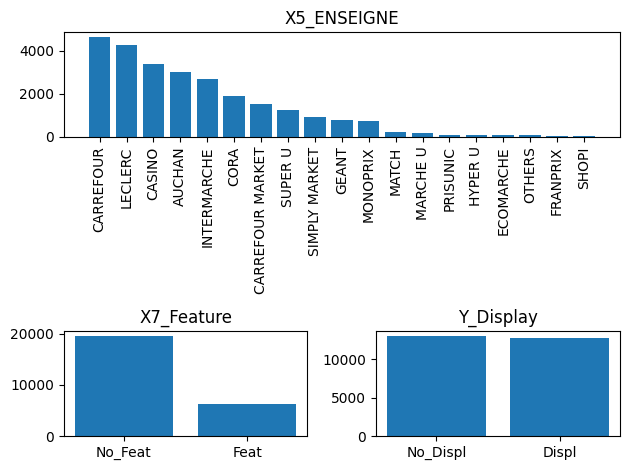

In [12]:
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

for cat, ax in zip(categorical_features + target, [ax1, ax2, ax3]):
    ax.bar(df[cat].value_counts().index, df[cat].value_counts().values)
    ax.set_title(cat)

for label in ax1.get_xticklabels():
    label.set_rotation(90)

plt.tight_layout()
plt.show()

- The target only has 2 classes being equally represented.
- The feature `X5` has 19 classes with different presentations, let's look at the exact count of each class to decide on how to group them.

In [13]:
df['X5_ENSEIGNE'].value_counts()

X5_ENSEIGNE
CARREFOUR           4629
LECLERC             4257
CASINO              3370
AUCHAN              3003
INTERMARCHE         2701
CORA                1883
CARREFOUR MARKET    1500
SUPER U             1265
SIMPLY MARKET        913
GEANT                761
MONOPRIX             732
MATCH                241
MARCHE U             153
PRISUNIC              99
HYPER U               71
ECOMARCHE             69
OTHERS                60
FRANPRIX              48
SHOPI                 27
Name: count, dtype: int64

We can group every store below `MONOPRIX` in a category called `OTHER`, if we find that they have similar properties and associations with other features.

### Associations Among Features

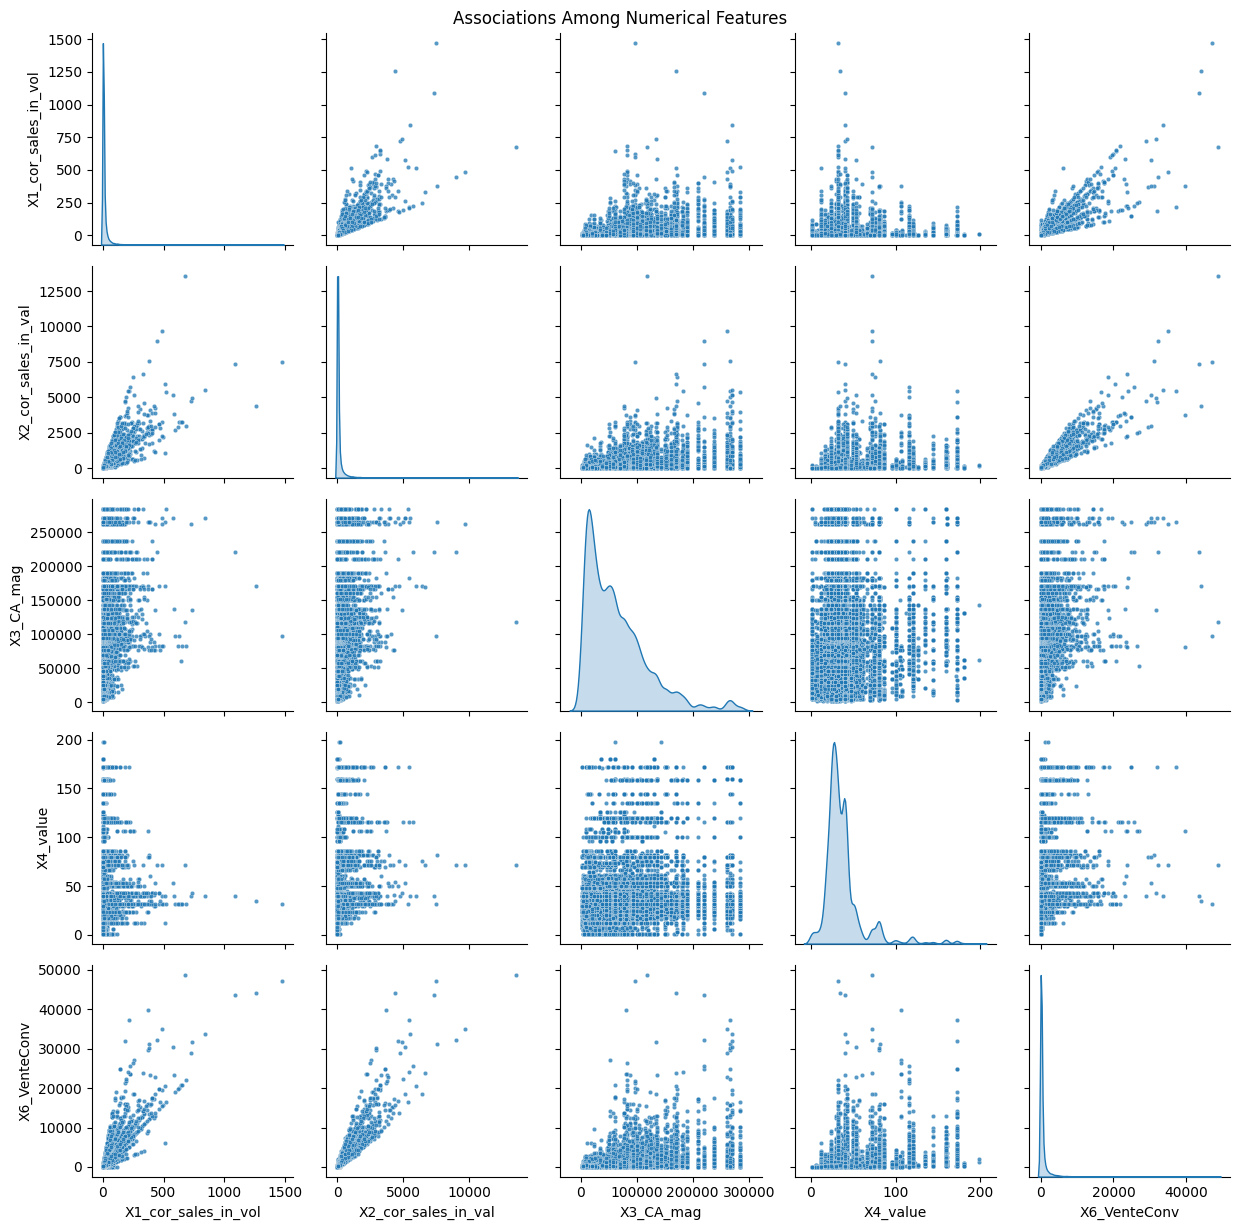

In [14]:
sns.pairplot(data=df[numerical_features], diag_kind='kde', plot_kws={'s': 10, 'alpha': 0.75})
plt.suptitle('Associations Among Numerical Features')
plt.tight_layout()
plt.show()

- We notice that there is a strong association between `X1` and `X2` and `X6`, maybe because from their names it seems that they are all related to sales.

In [15]:
df[numerical_features].corr()

,X1_cor_sales_in_vol,X2_cor_sales_in_val,X3_CA_mag,X4_value,X6_VenteConv
X1_cor_sales_in_vol,1.000000,0.858353,0.266049,0.077496,0.882588
X2_cor_sales_in_val,0.858353,1.000000,0.297886,0.230587,0.928348
X3_CA_mag,0.266049,0.297886,1.000000,0.127276,0.275925
X4_value,0.077496,0.230587,0.127276,1.000000,0.288883
X6_VenteConv,0.882588,0.928348,0.275925,0.288883,1.000000


- The correlation coefficients also suggest the same conclusion, which is the strong correlation between `X1`, `X2` and `X6`.

In [16]:
def hist_and_box_plot_by_target(col):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='Y_Display', ax=ax[0], bins=30)
    sns.boxplot(data=df, x=col, y='Y_Display', ax=ax[1])
    plt.suptitle(col)
    plt.tight_layout()
    plt.show()

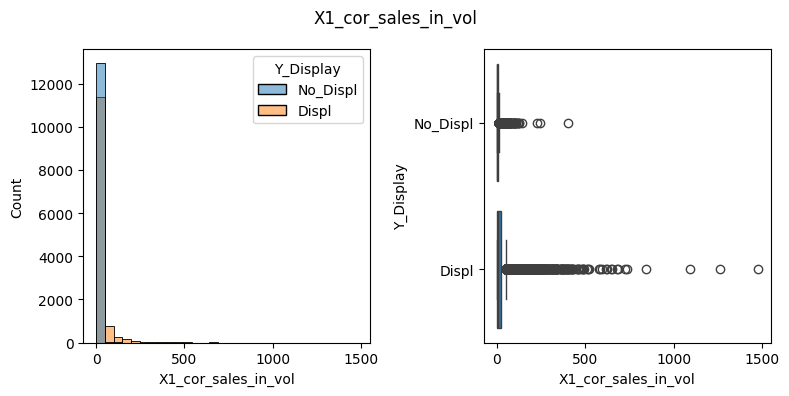

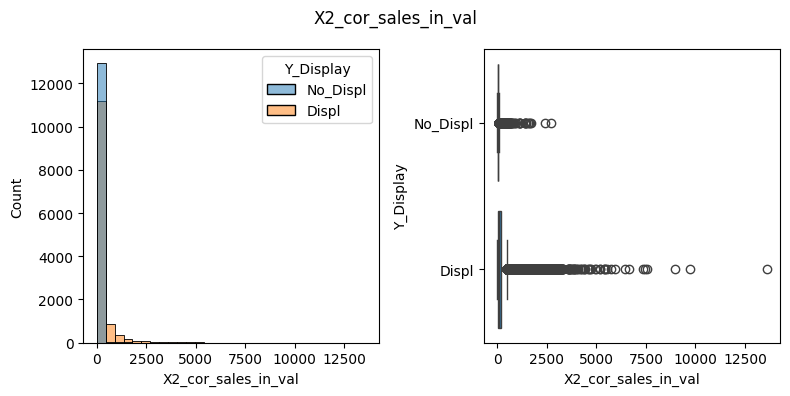

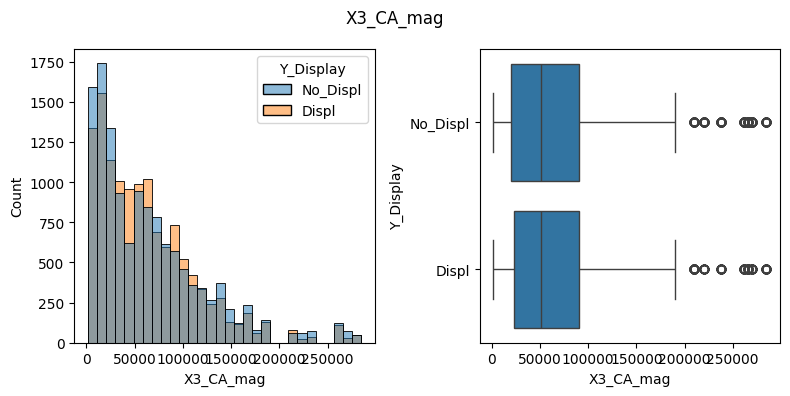

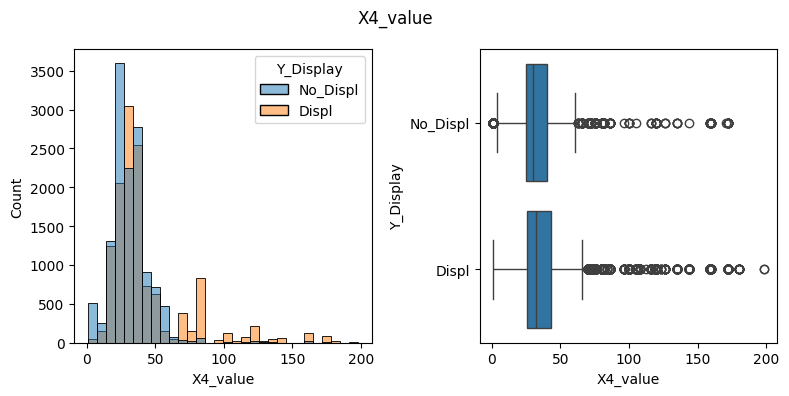

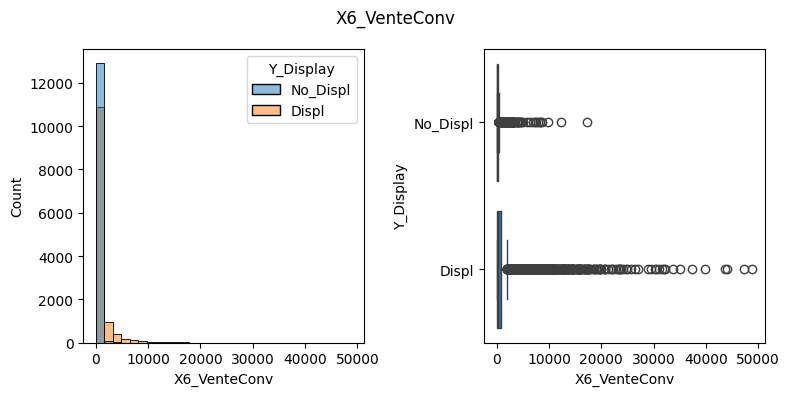

In [17]:
for col in numerical_features:
    hist_and_box_plot_by_target(col)

- The distribution of each numerical variable by target suggests that overall, observations with the class `Disp` tends to have higher values for features related to sales (1, 2 and 5).
- For the features 4 and 5, we don't see a significant difference in the distribution by target, both classes seem to have the same median and interquartile range, with the class `Disp` having slightly more observations with high values.

In [18]:
def chi_square_test(serie1, serie2):
    contingency_table = pd.crosstab(serie1, serie2)
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(contingency_table)
    print("chi2 statistic", chi2)
    print("p-value", p)
    print("degrees of freedom", dof)
    print("expected frequencies table", expected)

In [19]:
chi_square_test(df['Y_Display'], df['X7_Feature'])
print(pd.crosstab(df['Y_Display'], df['X5_ENSEIGNE']))

X7_Feature  Feat  No_Feat
Y_Display                
Displ       5912     6870
No_Displ     375    12625
chi2 statistic 6571.643703811071
p-value 0.0
degrees of freedom 1
expected frequencies table [[3116.92009929 9665.07990071]
 [3170.07990071 9829.92009929]]
X5_ENSEIGNE  AUCHAN  CARREFOUR  CARREFOUR MARKET  CASINO  CORA  ECOMARCHE  \
Y_Display                                                                   
Displ          1313       2364               731    2239   780         45   
No_Displ       1690       2265               769    1131  1103         24   

X5_ENSEIGNE  FRANPRIX  GEANT  HYPER U  INTERMARCHE  LECLERC  MARCHE U  MATCH  \
Y_Display                                                                      
Displ               6    482       36         1378     1930        54     96   
No_Displ           42    279       35         1323     2327        99    145   

X5_ENSEIGNE  MONOPRIX  OTHERS  PRISUNIC  SHOPI  SIMPLY MARKET  SUPER U  
Y_Display                            

The results we get from the above test are the following:
- First, the assumptions that are required for performing the chi square test are satisfied.
    - The observations are independent (naïve assumption).
    - Each cell from the contingency table has enough counts to ensure that we get reliable results.
    - Our features are indeed categorical.
- Without looking at the statistic and probability, we see a huge difference between the cells in the contingency table, and we can already tell that the two variables are not independent.
- The chi-statistic is very high, with a p value very close to 0, we are sure that the two variables are highly dependent on each others.

For the other categorical feature:
- We cannot perform the chi-square test, because of the many classes that exist, that could lead to unreliable results.
- When we look at the value of the contingency table, we can tell that maybe these features are also not independent.
- The best thing we can do here is to combine the rare categories into one, and then perform the chi-square test and conclude.

In [20]:
others = df['X5_ENSEIGNE'].value_counts().index[(df['X5_ENSEIGNE'].value_counts().values < 300)]
df.loc[df['X5_ENSEIGNE'].isin(others), 'X5_ENSEIGNE'] = 'OTHERS'

In [21]:
chi_square_test(df['Y_Display'], df['X5_ENSEIGNE'])

X5_ENSEIGNE  AUCHAN  CARREFOUR  CARREFOUR MARKET  CASINO  CORA  GEANT  \
Y_Display                                                               
Displ          1313       2364               731    2239   780    482   
No_Displ       1690       2265               769    1131  1103    279   

X5_ENSEIGNE  INTERMARCHE  LECLERC  MONOPRIX  OTHERS  SIMPLY MARKET  SUPER U  
Y_Display                                                                    
Displ               1378     1930       394     314            293      564  
No_Displ            1323     2327       338     454            620      701  
chi2 statistic 722.3700384950369
p-value 8.623742759881191e-148
degrees of freedom 11
expected frequencies table [[1488.80404934 2294.92971841  743.6583663  1670.75246296  933.53913583
   377.28267784 1339.08083159 2110.50244357  362.90528276  380.75308355
   452.64005896  627.15188891]
 [1514.19595066 2334.07028159  756.3416337  1699.24753704  949.46086417
   383.71732216 1361.91916841 2146.

Now that all the count values in each cell are high enough to be certain about the results, we can confidently say that the `X7` feature is also associated with the target.

Let's reorganize the columns and save the dataset for the preprocessing step.

In [22]:
df = df[numerical_features + categorical_features + target]
df.head()

,X1_cor_sales_in_vol,X2_cor_sales_in_val,X3_CA_mag,X4_value,X6_VenteConv,X5_ENSEIGNE,X7_Feature,Y_Display
0,2.0,20.20,47400,36,72.0,CORA,No_Feat,No_Displ
1,2.0,11.90,62000,24,48.0,LECLERC,No_Feat,No_Displ
2,8.0,29.52,60661,60,480.0,AUCHAN,No_Feat,No_Displ
3,2.0,16.20,59677,19,38.0,CARREFOUR,No_Feat,No_Displ
4,5.0,62.10,142602,50,250.0,CORA,No_Feat,No_Displ


In [23]:
df.to_csv('../data/processed/sales_cleaned.csv', index=False)

## Conclusion

- The dataset contains 7 features (5 numerical and 2 categorical) and 1 target category with 2 classes (binary classificaition), both being represented equally.
- There are no missing values, and columns are encoded in suitable data types.
- Numerical features are right skewed.
- There is a strong correlation between `X1`, `X2` and `X6`.
- Categorical features are associated with the target.
- Rare classes for the `X5` feature are combined into one category called `OTHER`.

We will take the new version of the data to the preprocessing step, where we'll build pipelines for transforming numerical (binning) and categorical features (encoding).